## Objective

Grad-CAM을 통해 우리는 이미지의 어떤 영역이 중요한지를 히트맵을 통해 시각화할 수 있지만, 상세한 이미지의 특성을 잡아내긴 어렵습니다. Guided Backpropagation을 이용하면, 명확한 이미지의 특성 및 윤곽을 확인할 수 있습니다. 

Guided Grad-CAM은 Grad-CAM으로 얻어진 Heat Map과 Guided BackPropagation으로 얻어진 Heat Map을 결합한 시각화 방법론입니다. 이 모형을 직접 코드로 작성하며 파악해보도록 하겠습니다.

**reference**
* [paper : Grad-CAM: Visual Explanations from Deep Networks
via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

### Guided Grad-CAM : Input의 어느 세부 특성이 중요했나?



Guided Backpropagation은 *Striving For Simplicity: The All Convolution Net*에서 제안한 시각화 방법론입니다. Gradient을 활용하여 영상 내에서 어떤 요소가 유의미한지를 판단하는 기법으로, 높은 해상도의 정보로 구체적인 시각 형태를 잡아내는데 쓰입니다.


![Imgur](https://i.imgur.com/pTzarAO.png)

Guided Back Propagation의 핵심은 역전파 과정 중에서, Relu의 역전파 식을 보정하는 데에 있습니다. Relu의 역전파 과정에서는 Input이 음수인 방향으로는 Gradient를 흘러보내지 않는데, 거기에 더해 gradient가 0인 것도 같이 안 보내게 되면 그것이 바로 Guided Back Propagation입니다.

$$
R^{l}_i = (f^{i}_i>0)\cdot(R_i^{i+1}>0)\cdot R^{l+1}_i
$$

Guided Backpropagation은 양수의 Gradient만 이미지 재구축에 참여하게 함으로써, 좀 더 깔끔한 이미지로 재구축을 할 수 있습니다.

### Guided Grad-CAM 구현하기


#### - 모듈 가져오기

필요한 모듈은 아래와 같습니다.

In [61]:
%matplotlib inline
import os
import cv2

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

#### - 이미지 가져오기 

강아지와 레서판다 이미지가 있습니다. 이 두 이미지를 통해 어떤 식으로 GradCAM이 동작하는지를 파악해보도록 하겠습니다.

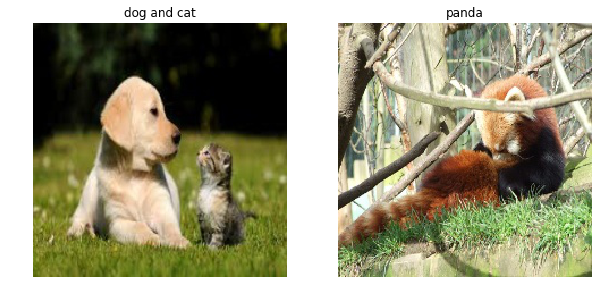

In [9]:
from tensorflow.keras.utils import get_file

ROOT_URL = "https://craftsangjae.s3.ap-northeast-2.amazonaws.com/images/"

dog_path = get_file("dog_and_cat.jpg", ROOT_URL+"dog_and_cat.jpg")
dog_image = plt.imread(dog_path)

panda_path = get_file("redpanda.jpg", ROOT_URL+"redpanda.jpg")
panda_image = plt.imread(panda_path)

fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title("dog and cat")
ax[0].imshow(dog_image)
ax[0].axis('off')

ax[1].set_title("panda")
ax[1].imshow(panda_image)
ax[1].axis('off')
plt.show()

#### - Guided BackPropagation 연산자 구현하기

Tensorflow에서는 각 연산자 별 역전파 수식이 이미 결정되어 있습니다. 이를 변경하기 위해서는, 새로운 역전파 수식을 구현해서 덮어씌어 주어야 합니다. 아래의 코드를 통해, guidedRelu라는 새로운 역전파 코드를 작성하고, 그것을 relu에 덮어씌우는 방식으로 진행하였습니다.

reference : [stackoverflow : How to replace or modify gradient](https://stackoverflow.com/questions/43839431/tensorflow-how-to-replace-or-modify-gradient)

In [10]:
from tensorflow.keras.utils import get_custom_objects

@tf.custom_gradient
def guidedrelu(x):
    a = tf.maximum(x,0.)
    def grad(dy):
        relu_mask = tf.cast(x > 0., tf.float32)
        guided_mask = tf.cast(dy > 0., tf.float32)
        return dy * guided_mask * relu_mask
    return a, grad

get_custom_objects().update({'relu':guidedrelu})

#### - VGG 모델 가져오기

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

vgg16 = VGG16()

for layer in vgg16.layers[::-1]:
    if 'conv' in layer.name:
        last_conv_layer = layer
        break

feature_map = last_conv_layer.output
class_output = vgg16.output

grad_model = Model(vgg16.input, [feature_map, class_output])

#### - guided Grad-CAM 메소드 구성하기

In [12]:
def get_guided_cam(image):
    image = tf.constant(image, tf.float32)
    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(image)
        conv_outputs, model_outputs = grad_model(image[None])

        top_indices = tf.argmax(model_outputs, axis=1)
        top_logit = tf.gather(model_outputs, top_indices, axis=1)

    grads = tape.gradient(top_logit, conv_outputs)
    channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                        keepdims=True)
    heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                             axis=-1, keepdims=True)
    heat_map = tf.nn.relu(heat_map)

    heat_map = tf.image.resize(heat_map, image.shape[:2])

    saliency_map = tape.gradient(top_logit, image)
    guided_heat_map = saliency_map * heat_map
    
    return heat_map[0], saliency_map, guided_heat_map


### 결과 시각화하기


#### 개와 고양이 사진

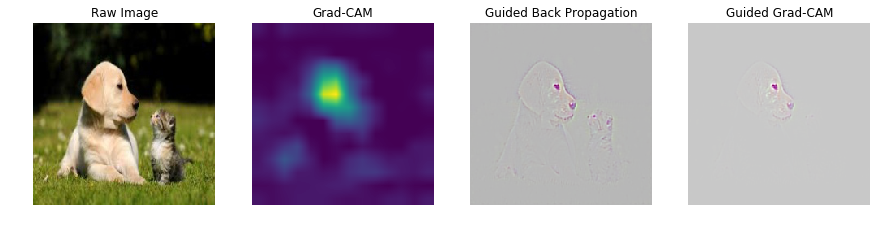

In [22]:
image = dog_image - [123.68,116.779,103.939,]

res_heat_map, res_saliency, res_guided = get_guided_cam(image)

res_heat_map = np.squeeze(res_heat_map) # (1,H,W,1) -> (H,W)
res_saliency = np.squeeze(res_saliency) # (1,H,W,C) -> (H,W,C)
res_guided = np.squeeze(res_guided) # (1,H,W,C) -> (H,W,C)

norm_saliency = ((res_saliency - res_saliency.min())/
                (res_saliency.max() - res_saliency.min()))
norm_guided = ((res_guided - res_guided.min())/
                (res_guided.max() - res_guided.min()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,4,1)
ax.set_title("Raw Image")
ax.imshow(dog_image); ax.axis('off')

ax = fig.add_subplot(1,4,2)
ax.set_title("Grad-CAM")
ax.imshow(res_heat_map)
ax.axis('off')

ax = fig.add_subplot(1,4,3)
ax.set_title("Guided Back Propagation")
ax.imshow(norm_saliency)
ax.axis('off')

ax = fig.add_subplot(1,4,4)
ax.set_title("Guided Grad-CAM")
ax.imshow(norm_guided)
ax.axis('off')

plt.show()

#### - 판다 사진에 시각화하기

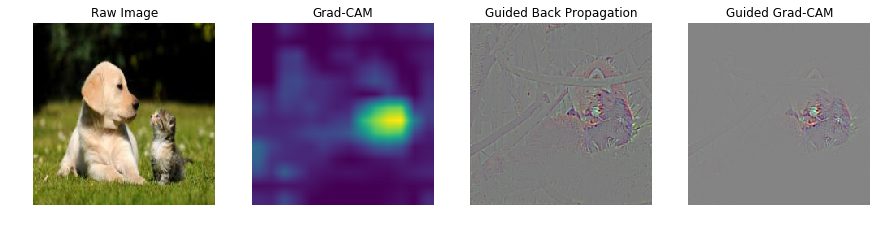

In [24]:
image = panda_image - [123.68,116.779,103.939,]

res_heat_map, res_saliency, res_guided = get_guided_cam(image)

res_heat_map = np.squeeze(res_heat_map) # (1,H,W,1) -> (H,W)
res_saliency = np.squeeze(res_saliency) # (1,H,W,C) -> (H,W,C)
res_guided = np.squeeze(res_guided) # (1,H,W,C) -> (H,W,C)

norm_saliency = ((res_saliency - res_saliency.min())/
                (res_saliency.max() - res_saliency.min()))
norm_guided = ((res_guided - res_guided.min())/
                (res_guided.max() - res_guided.min()))

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,4,1)
ax.set_title("Raw Image")
ax.imshow(dog_image); ax.axis('off')

ax = fig.add_subplot(1,4,2)
ax.set_title("Grad-CAM")
ax.imshow(res_heat_map)
ax.axis('off')

ax = fig.add_subplot(1,4,3)
ax.set_title("Guided Back Propagation")
ax.imshow(norm_saliency)
ax.axis('off')

ax = fig.add_subplot(1,4,4)
ax.set_title("Guided Grad-CAM")
ax.imshow(norm_guided)
ax.axis('off')

plt.show()